In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from obspy.core.trace import Trace, Stats
from obspy.core.stream import Stream
from obspy import UTCDateTime
from obspy.clients.fdsn import Client

from obspy.imaging.beachball import beachball
from obspy.imaging.beachball import beach
from obspy.imaging.source import plot_radiation_pattern

from matplotlib.patches import Rectangle
import matplotlib.patches
import matplotlib.ticker as ticker


client = Client("IRIS")

In [4]:
%matplotlib notebook

In [5]:
def rotate(c1,c2,a):
    """
    IN: c1,c2 (arrays) and a (angle)
    c1 c2 are the X and Y axes, respectively of a Cartesian coordinate system
    a is an angle in degrees, positive angle means a clockwise rotation of the coordinate system.
    OUT: o1, o2 (arrays)
    o1 o2 are the X and Y axes, respectively of a rotated Cartesian coordinate system
    """
    o1 = np.cos(np.radians(a))*c1 - np.sin(np.radians(a))*c2
    o2 = np.sin(np.radians(a))*c1 + np.cos(np.radians(a))*c2
    return o1, o2

In [6]:
def waveforms_COR(start, end, adjtime):
    st_raw = client.get_waveforms('IU', 'COR', '00', "B*", start-adjtime, end+adjtime, attach_response=True)
    st = st_raw.copy()
    st_filt = st.filter('lowpass', freq = 0.1)
    st_disp = st_filt.remove_response(output='DISP')
    # st_disp.plot()
    return st_disp

def rot2enz_COR(st,angles):
    BAz = angles[0]
    Pincd = angles[1]
    Sincd = angles[2]

    if len(st) != 3:
       print('Stream does not contain 3 Traces')
       return st
    for trace in st:
        head = trace.stats
        channel = head.channel
        if channel == 'BH1': one = trace.data
        elif channel == 'BH2': two = trace.data
        elif channel == 'BHZ': Z = trace.data
        else:
            print('Trace.channel is not BH1, BH2, or BHZ')
            return st

    E,N = rotate(two, one, -130)

    head.channel = 'BHE'; trE = Trace(data=E, header=head)
    head.channel = 'BHN'; trN = Trace(data=N, header=head)
    head.channel = 'BHZ'; trZ = Trace(data=Z, header=head)
    stENZ = Stream(traces=[trE,trN,trZ])
    
    hhe = stENZ[0].data
    hhn = stENZ[1].data
    hhz = stENZ[2].data

    #hhT,hhR = rotate(hhe,hhn,BAz)
    #head.channel = 'BHT'; trT = Trace(data=hhT, header=head)
    #head.channel = 'BHR'; trR = Trace(data=hhR, header=head)
    
    #phhQ,phhL = rotate(hhn,hhz,Pincd)
    #shhQ,shhL = rotate(hhn,hhz,Sincd)
    #head.channel = 'BHL'; trL = Trace(data=phhL, header=head)
    #head.channel = 'BHQ'; trQ = Trace(data=shhQ, header=head)
    
    hhT,hhR = rotate(trE,trN,BAz+180)
    head.channel = 'BHT'; trT = Trace(data=hhT, header=head)
    head.channel = 'BHR'; trR = Trace(data=hhR, header=head)
    
    phhQ,phhL = rotate(trR,trZ,Pincd)
    shhQ,shhL = rotate(trR,trZ,Sincd)
    head.channel = 'BHL'; trL = Trace(data=phhL, header=head)
    head.channel = 'BHQ'; trQ = Trace(data=shhQ, header=head)
    
    stALL = Stream(traces=[trE,trN,trZ,trT,trR,trL,trQ])

    return stALL

In [48]:
def paper_plot_COR(event,axs,st,angs,Pt,St,Ptime=0):
    if Ptime == 0: Ptime = st[0].stats.starttime
    time_axis = st[0].times(reftime=Ptime)
    n = min([len(time_axis)]+[len(st[i].data) for i in np.arange(len(st))])
    
# #     Pt = event_origin + 427
# #     St = event_origin + 773
#     Pt = 0
#     St = 773-427
    
#     sENZ = rot2enz_van(st,angs)
    st.plot()
    shift = 0; a = 1
    for trace in st:
        if trace.stats.channel == 'BHZ':
            axs[0][0].plot(time_axis[:n], a*trace.data[:n],lw=0.5, label = event + ": " + trace.stats.channel)
            axs[0][0].annotate(trace.stats.channel, xy=(Pt-10,shift+1e-07), size='x-small', color='k')
            axs[0][0].vlines(Pt,-3e-6,2.5e-06,color='k',linestyle='--',lw=1,alpha=0.5)
            axs[0][0].annotate('P', xy=(Pt-1,1e-07), size='small', color='k')
            axs[0][0].set_xlim(Pt-15,Pt+15)
        
        elif trace.stats.channel == 'BHL':
            axs[1][0].plot(time_axis[:n], a*trace.data[:n],lw=0.5, label = event + ": " + trace.stats.channel)
            axs[1][0].annotate(trace.stats.channel, xy=(Pt-10,shift+1e-07), size='x-small', color='k')
            axs[1][0].vlines(Pt,-3e-6,2.5e-06,color='k',linestyle='--',lw=1,alpha=0.5)
            axs[1][0].annotate('P', xy=(Pt-1,1e-07), size='small', color='k')
#             axs[1][0].set_xlim(Pt-15,Pt+15)
        
        elif trace.stats.channel == 'BHT':
            axs[0][1].plot(time_axis[:n], a*trace.data[:n],lw=0.5, label = event + ": " + trace.stats.channel)
            axs[0][1].annotate(trace.stats.channel, xy=(St-10,shift+1e-07), size='x-small', color='k')
            axs[0][1].vlines(St,-3e-6,2.5e-06,color='k',linestyle='--',lw=1,alpha=0.5)
            axs[0][1].annotate('S', xy=(St-1,1e-07), size='small', color='k')
            axs[0][1].set_xlim(St-15,St+15)
            
        elif trace.stats.channel == 'BHQ':
            axs[1][1].plot(time_axis[:n], a*trace.data[:n],lw=0.5, label = event + ": " + trace.stats.channel)
            axs[1][1].annotate(trace.stats.channel, xy=(St-10,shift+1e-07), size='x-small', color='k')
            axs[1][1].vlines(St,-3e-6,2.5e-06,color='k',linestyle='--',lw=1,alpha=0.5)
            axs[1][1].annotate('S', xy=(St-1,1e-07), size='small', color='k')
#             axs[1][1].set_xlim(St-15,St+15)

    ticks_y = ticker.FuncFormatter(lambda y, pos: '{0:g}'.format(y/1e-06))
    axs[0][0].yaxis.set_major_formatter(ticks_y)
    axs[0][1].yaxis.set_major_formatter(ticks_y)
    axs[1][0].yaxis.set_major_formatter(ticks_y)
    axs[1][1].yaxis.set_major_formatter(ticks_y)

        
def paper_patch(ax,Pt,Pst,Pend,St,Sst,Send,df):
    '''
    **input times as UTCDateTime objects**
    Pt & St : reported arrival times used
    Pst & Sst : start of time window
    Pend & Send : end of time window
    '''
    P_begin = Pst - Pt; P_end = Pend - Pt; Pdiff = Pend - Pst
    S_begin = Sst - Pt; S_end = Send - Pt; Sdiff = Send - Sst
    print(P_begin,P_end)
    print(S_begin,S_end)
    
    
    for index,row in df.iterrows():
        if df['Model'][index] == 'OurPicks':
            c = 'red'; liwi = 0.5; linest = '-'; alp = 0.5
            rat = 1

        elif df['Model'][index] == 'iasp91-COR':
            c = 'purple'; liwi = 0.5; linest = '-'; alp = 0.5
            synth = [0.206375, -0.313537, -0.293943]
            obs = [1.54e-06, -2.19e-06, -2.34e-06]

            A_o = np.sqrt(obs[0]**2 + obs[1]**2 + obs[2]**2)

            A_s = np.sqrt(synth[0]**2 + synth[1]**2 + synth[2]**2)

            rat = A_o/A_s
            
        elif df['Model'][index] == 'iasp91-ANMO':
            c = 'green'; liwi = 0.5; linest = '-'; alp = 0.5
            synth = [0.306913, -0.813469, -0.459511]
            obs = [1.54e-06, -2.19e-06, -2.34e-06]

            A_o = np.sqrt(obs[0]**2 + obs[1]**2 + obs[2]**2)

            A_s = np.sqrt(synth[0]**2 + synth[1]**2 + synth[2]**2)

            rat = A_o/A_s

        #horizontal model lines
        ax[1][0].hlines(rat*df['P'][index],P_begin,P_end,color=c,linestyle=linest,lw=liwi,alpha=alp)
        ax[0][1].hlines(rat*df['SH'][index],S_begin,S_end,color=c,linestyle=linest,lw=liwi,alpha=alp)
        ax[1][1].hlines(rat*df['SV'][index],S_begin,S_end,color=c,linestyle=linest,lw=liwi,alpha=alp)

352.49


<IPython.core.display.Javascript object>


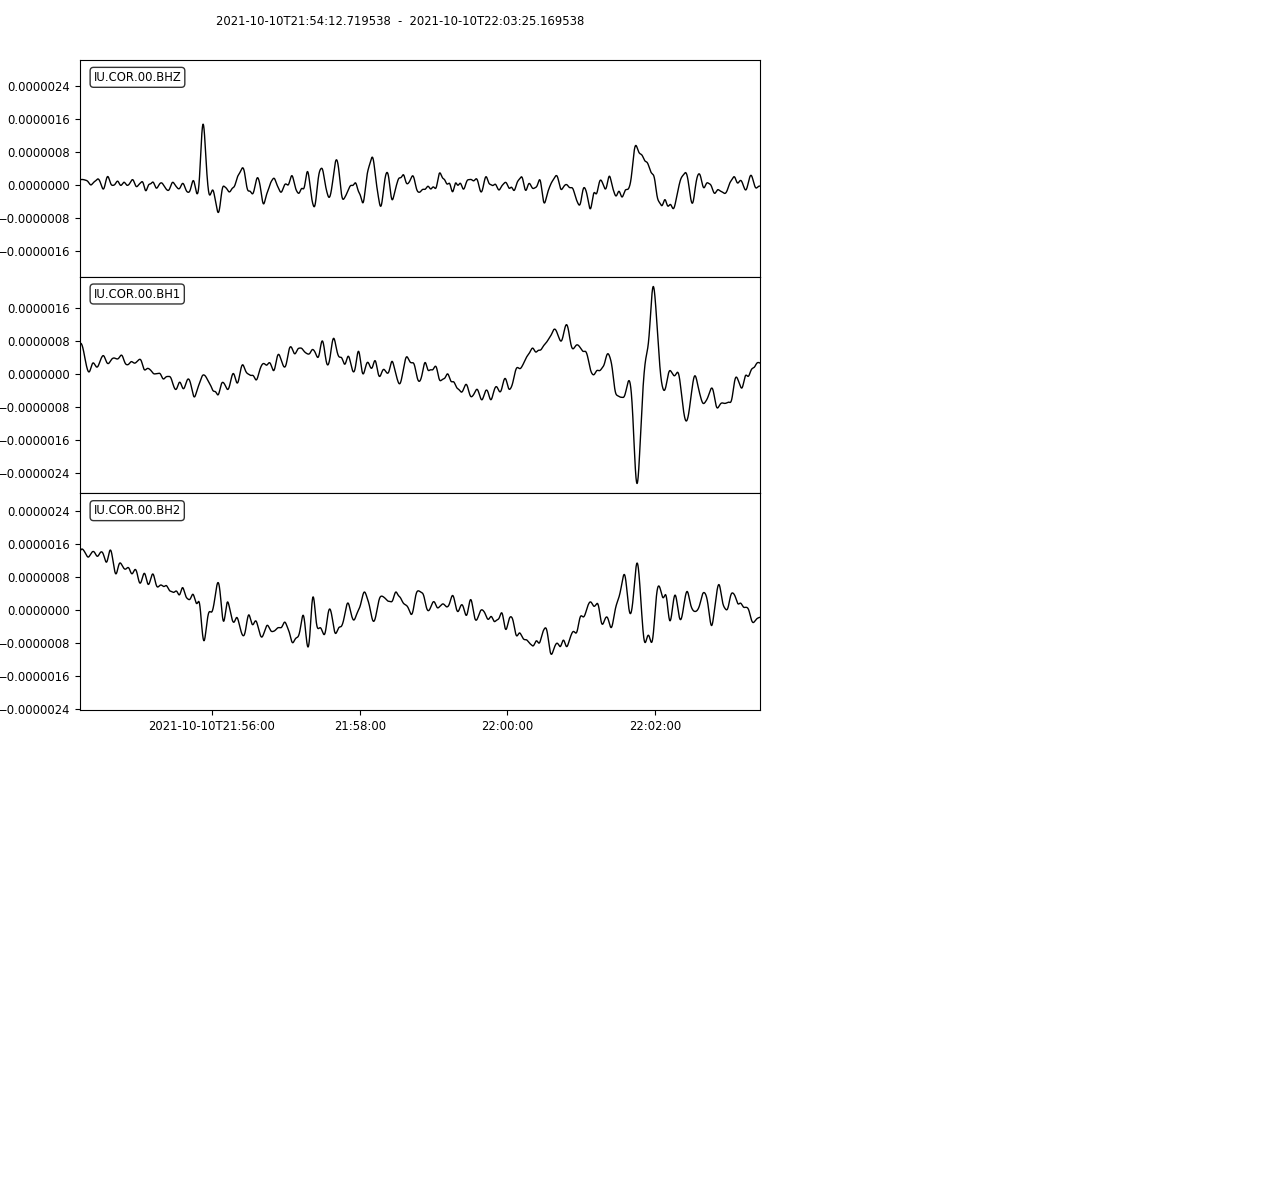

<IPython.core.display.Javascript object>

In [8]:
#COR

event_origin = UTCDateTime('2021-10-10T21:48:36.560')
Pt_COR = UTCDateTime('2021-10-10T21:55:52.7')
St_COR = UTCDateTime('2021-10-10T22:01:45.19')
arrival_diff = abs(Pt_COR-St_COR)
print(arrival_diff)

#STATION COR
# Pt_COR = event_origin + 427
# St_COR = event_origin + 773

bAz_COR = -123
dist_COR = 37.18
Pa_COR = 26.23
Sa_COR = 27.32

COR_ang = [bAz_COR,Pa_COR,Sa_COR]

st_z12 = waveforms_COR(Pt_COR,St_COR,100)
st_z12.plot();
st_all = rot2enz_COR(st_z12,COR_ang)
st_all.plot();

<IPython.core.display.Javascript object>


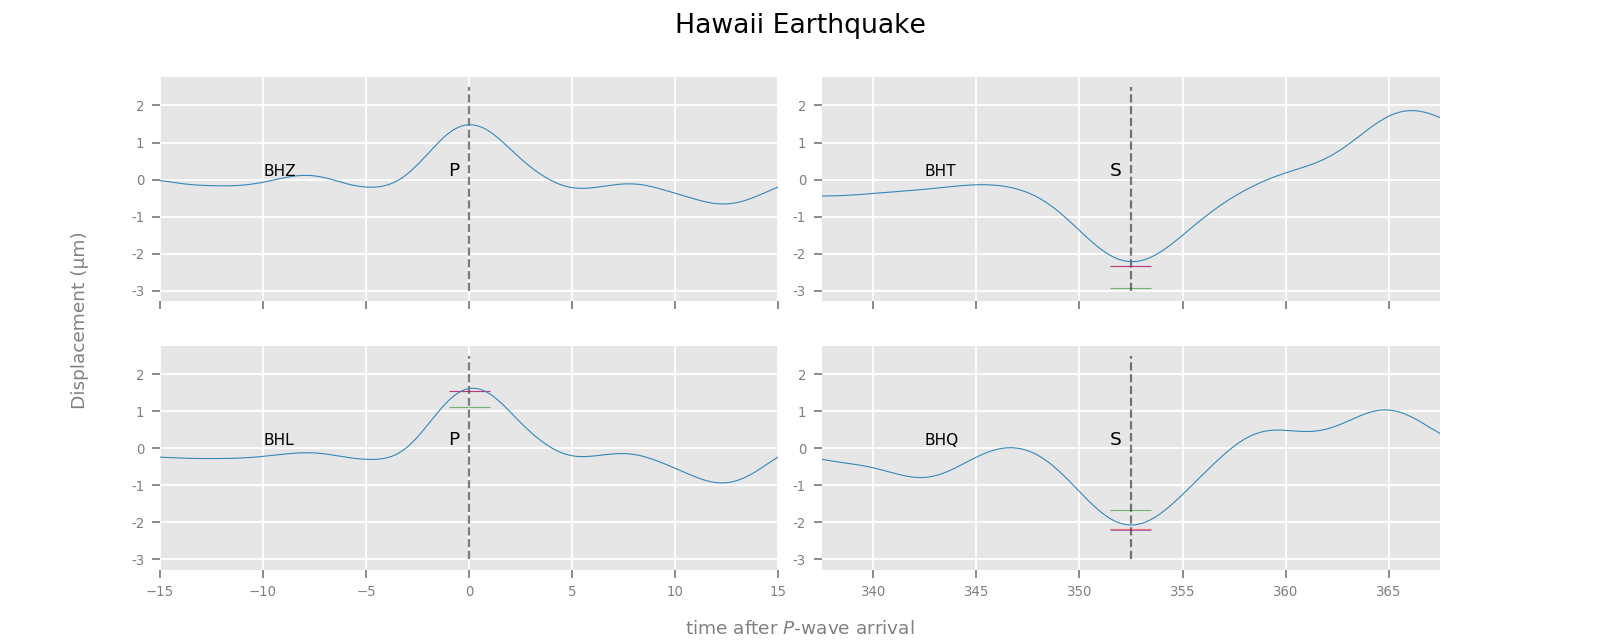

In [52]:
fig, aus = plt.subplots(2, 2, sharey=False, figsize=(10,4), sharex='col')
fig.suptitle('Hawaii Earthquake')
fig.text(0.5,0.02, "time after $P$-wave arrival", ha="center", va="center_baseline", color ='grey',fontsize='small')
fig.text(0.05,0.5, "Displacement (μm)", ha="center", va="center", rotation=90, color='grey',fontsize='small')


for j in range(2):
    aus[j][0].tick_params(labelsize=6)
    aus[j][1].tick_params(labelsize=6)
#     aus[j][0].errorbar(-12, 0, yerr=0.024, capsize=4, ecolor='k', elinewidth=1)
#     aus[j][1].errorbar(162, 0, yerr=0.186, capsize=4, ecolor='k', elinewidth=1)

plt.subplots_adjust(left=0.1,wspace=0.07)

from matplotlib import cycler

colors = cycler('color',
                ['#3388BB', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('axes', facecolor='#E6E6E6', edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors)
plt.rc('grid', color='w', linestyle='solid')
plt.rc('xtick', color='grey', direction='out'); plt.rc('ytick', color='grey', direction='out')
fig.patch.set_facecolor('white')

         Model           P          SH          SV
0     OurPicks  0.00000154 -0.00000234 -0.00000219
1   iasp91-COR  0.20637500 -0.31353700 -0.29394300
2  iasp91-ANMO  0.30691300 -0.81346900 -0.45951100


<IPython.core.display.Javascript object>


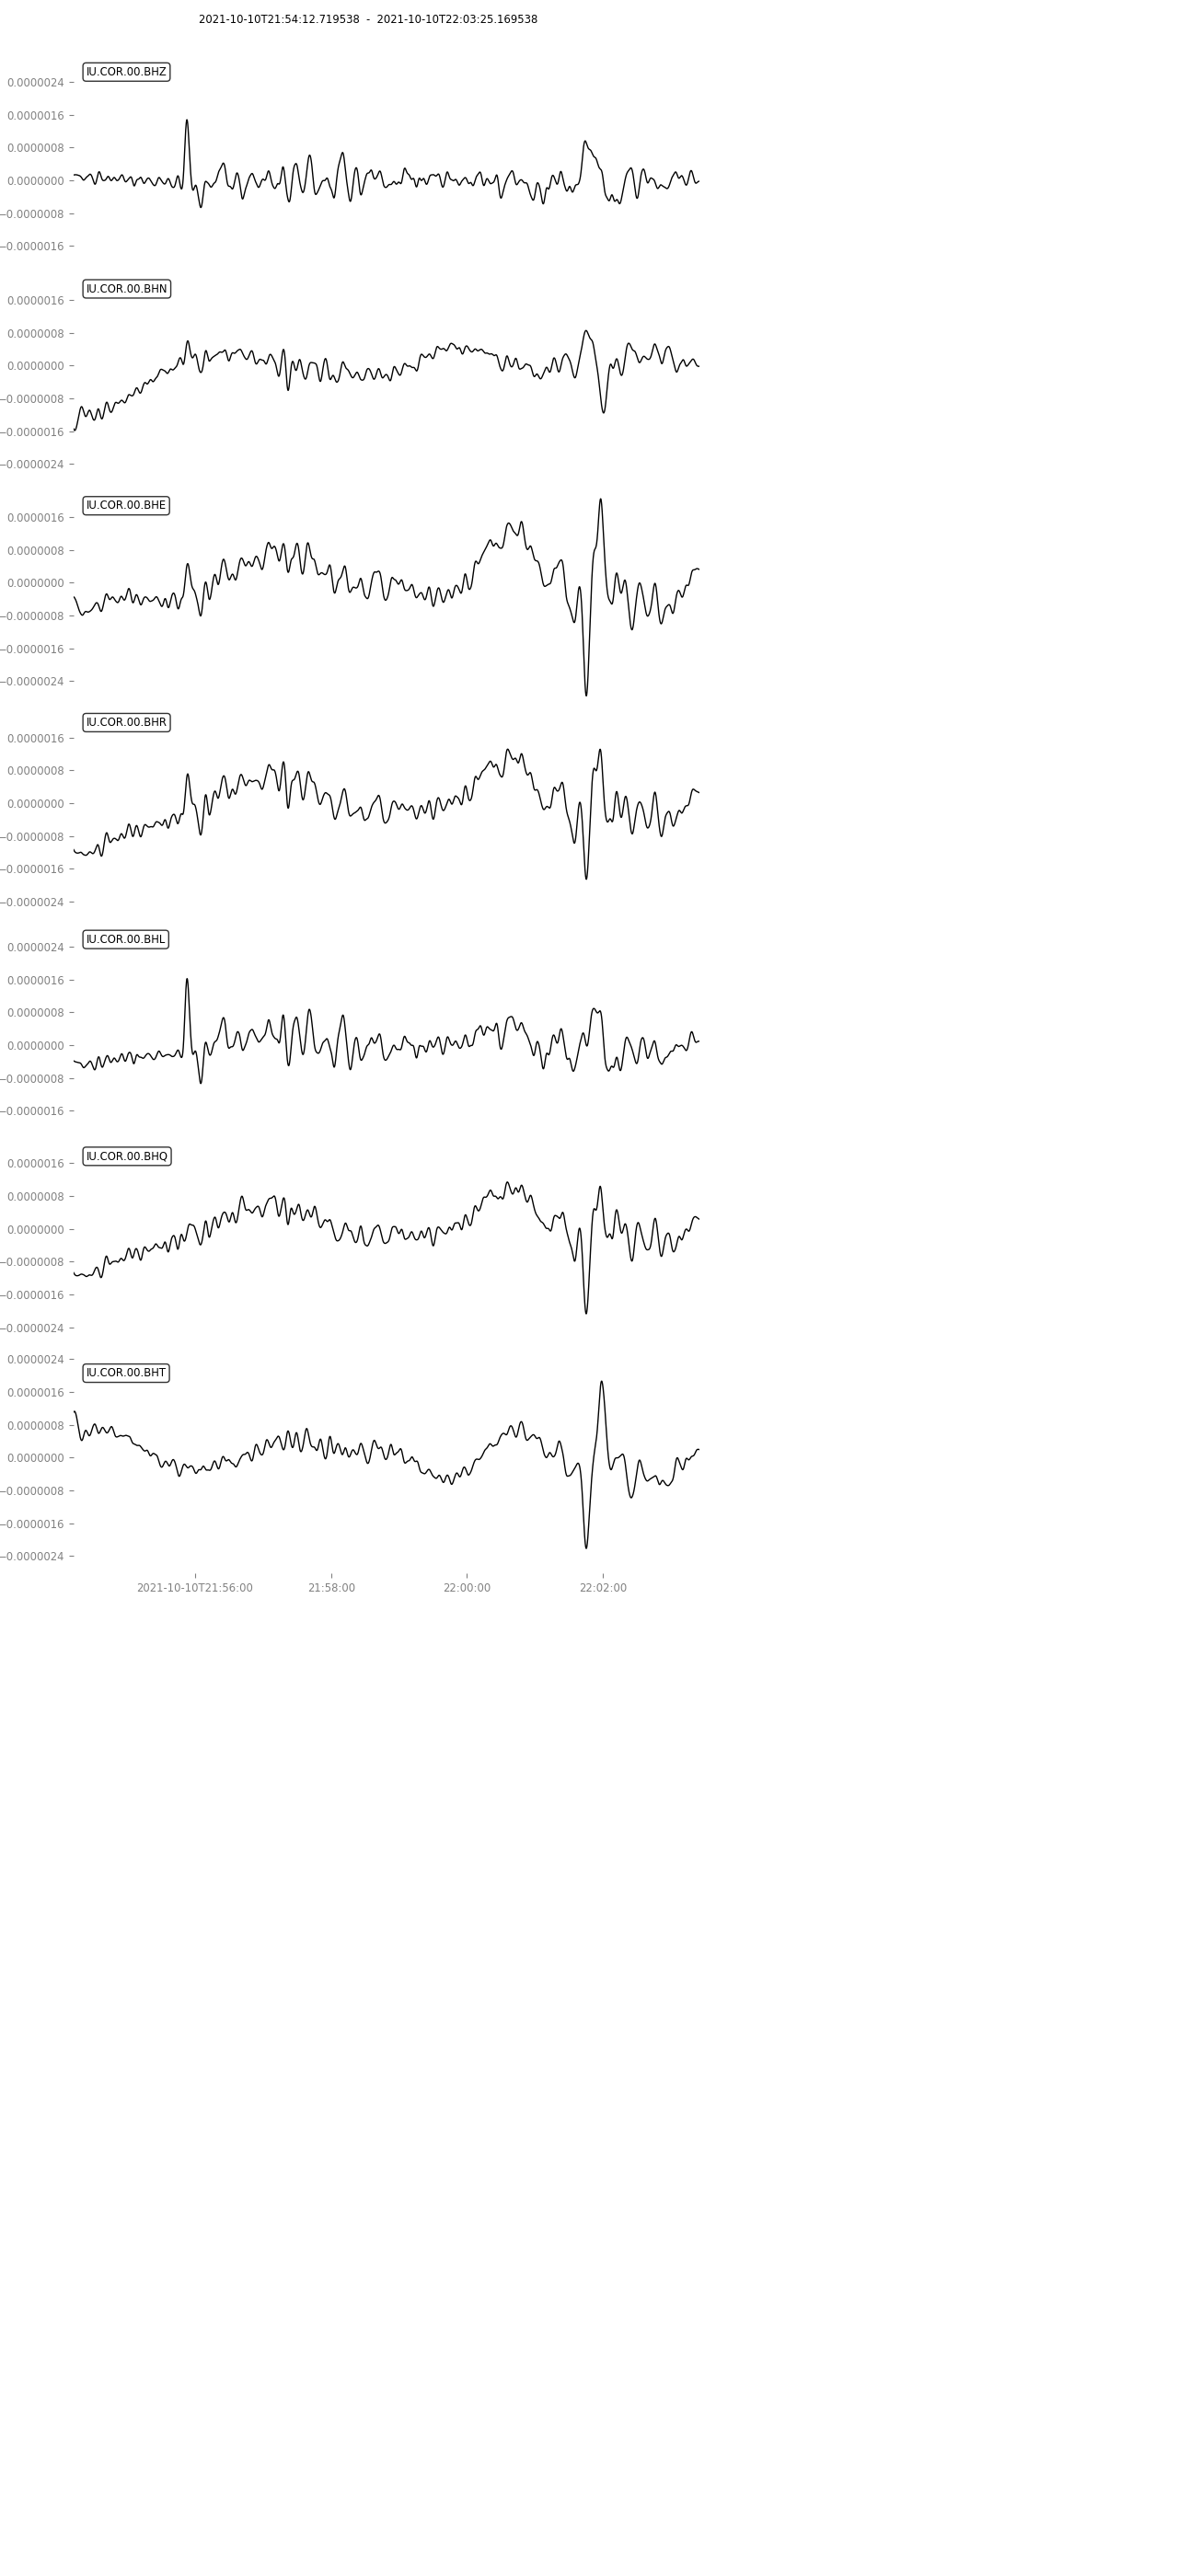

-1.0 1.0
351.49 353.49


In [53]:
obs_COR = {'Model':'OurPicks', 'P': 1.54e-06, 'SH':-2.34e-06, 'SV':-2.19e-06}
syn_COR = {'Model':'iasp91-COR', 'P':0.206375, 'SV':-0.293943, 'SH': -0.313537}
syn_ANMO = {'Model': 'iasp91-ANMO', 'P': 0.306913, 'SV':-0.459511, 'SH':-0.813469}
COR_amps = pd.DataFrame([obs_COR, syn_COR, syn_ANMO])
pd.set_option("display.precision", 9)
print(COR_amps)

paper_plot_COR('Hawaii Earthquake',aus,st_all,COR_ang,0,arrival_diff,Ptime=Pt_COR)
paper_patch(aus,Pt_COR,Pt_COR-1,Pt_COR+1,St_COR,St_COR-1,St_COR+1,COR_amps)

<IPython.core.display.Javascript object>


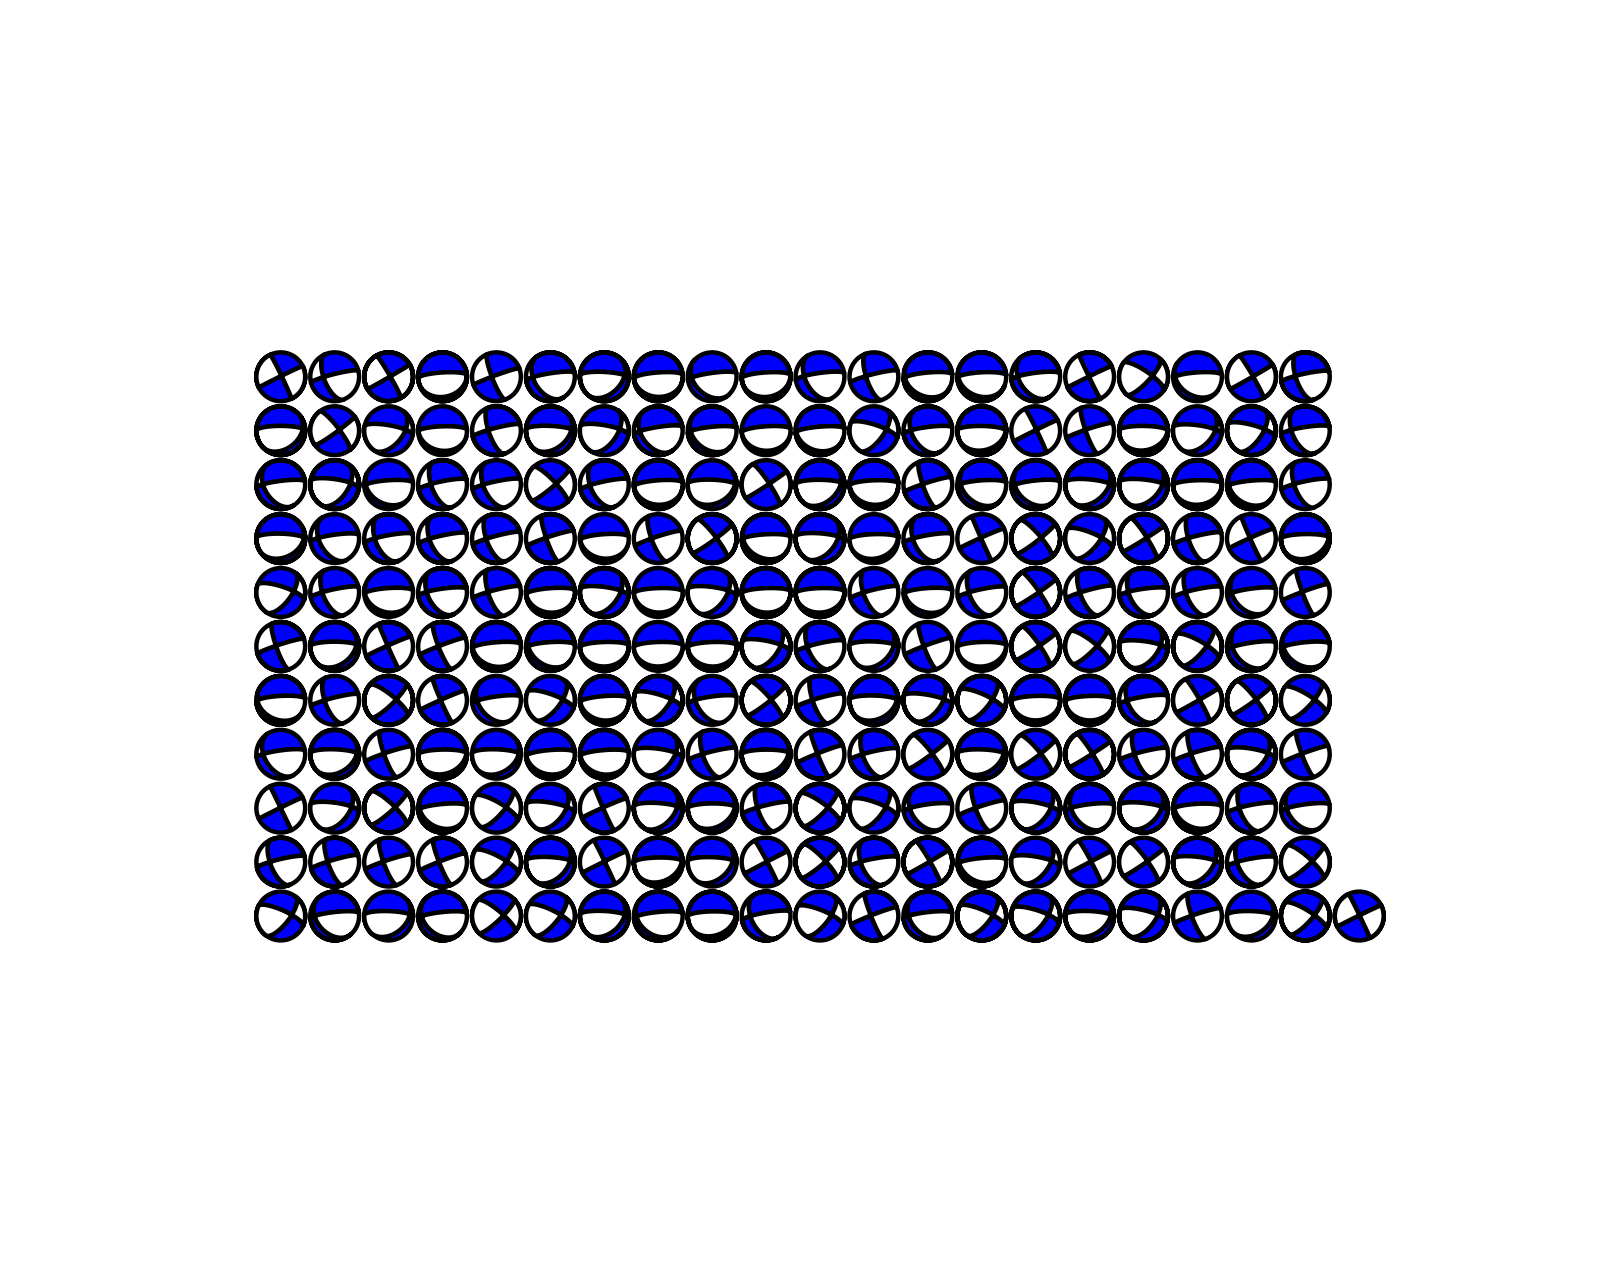

/anaconda3/envs/REU2020/lib/python3.7/site-packages/obspy/imaging/beachball.py:254: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111, aspect='equal')


In [28]:
df = pd.read_csv('/Users/maddysita/Desktop/CIERA_REU/event-by-event/EARTHQUAKE/eqCOR_march.csv')

df = df.sort_values('Misfit')

fig = plt.figure(figsize=(10,8))

n = 0
for index,rows in df.iterrows():
    f = [rows.Strike, rows.Dip, rows.Rake]

    if n <= 20:
        fault = beachball(f, xy=(210*n,0), fig=fig)

    elif n <= 40:
        fault = beachball(f, xy=(210*(n-21),210), fig=fig)

    elif n <= 60:
        fault = beachball(f, xy=(210*(n-41),420), fig=fig)

    elif n <= 80:
        fault = beachball(f, xy=(210*(n-61),630), fig=fig)

    elif n <= 100:
        fault = beachball(f, xy=(210*(n-81),840), fig=fig)

    elif n <= 120:
        fault = beachball(f, xy=(210*(n-101),1050), fig=fig)

    elif n <= 140:
        fault = beachball(f, xy=(210*(n-121),1260), fig=fig)

    elif n <= 160:
        fault = beachball(f, xy=(210*(n-141),1470), fig=fig)

    elif n <= 180:
        fault = beachball(f, xy=(210*(n-161),1680), fig=fig)

    elif n <= 200:
        fault = beachball(f, xy=(210*(n-181),1890), fig=fig)
        
    elif n <= 220:
        fault = beachball(f, xy=(210*(n-201),2100), fig=fig)
        
    n+=1

<IPython.core.display.Javascript object>


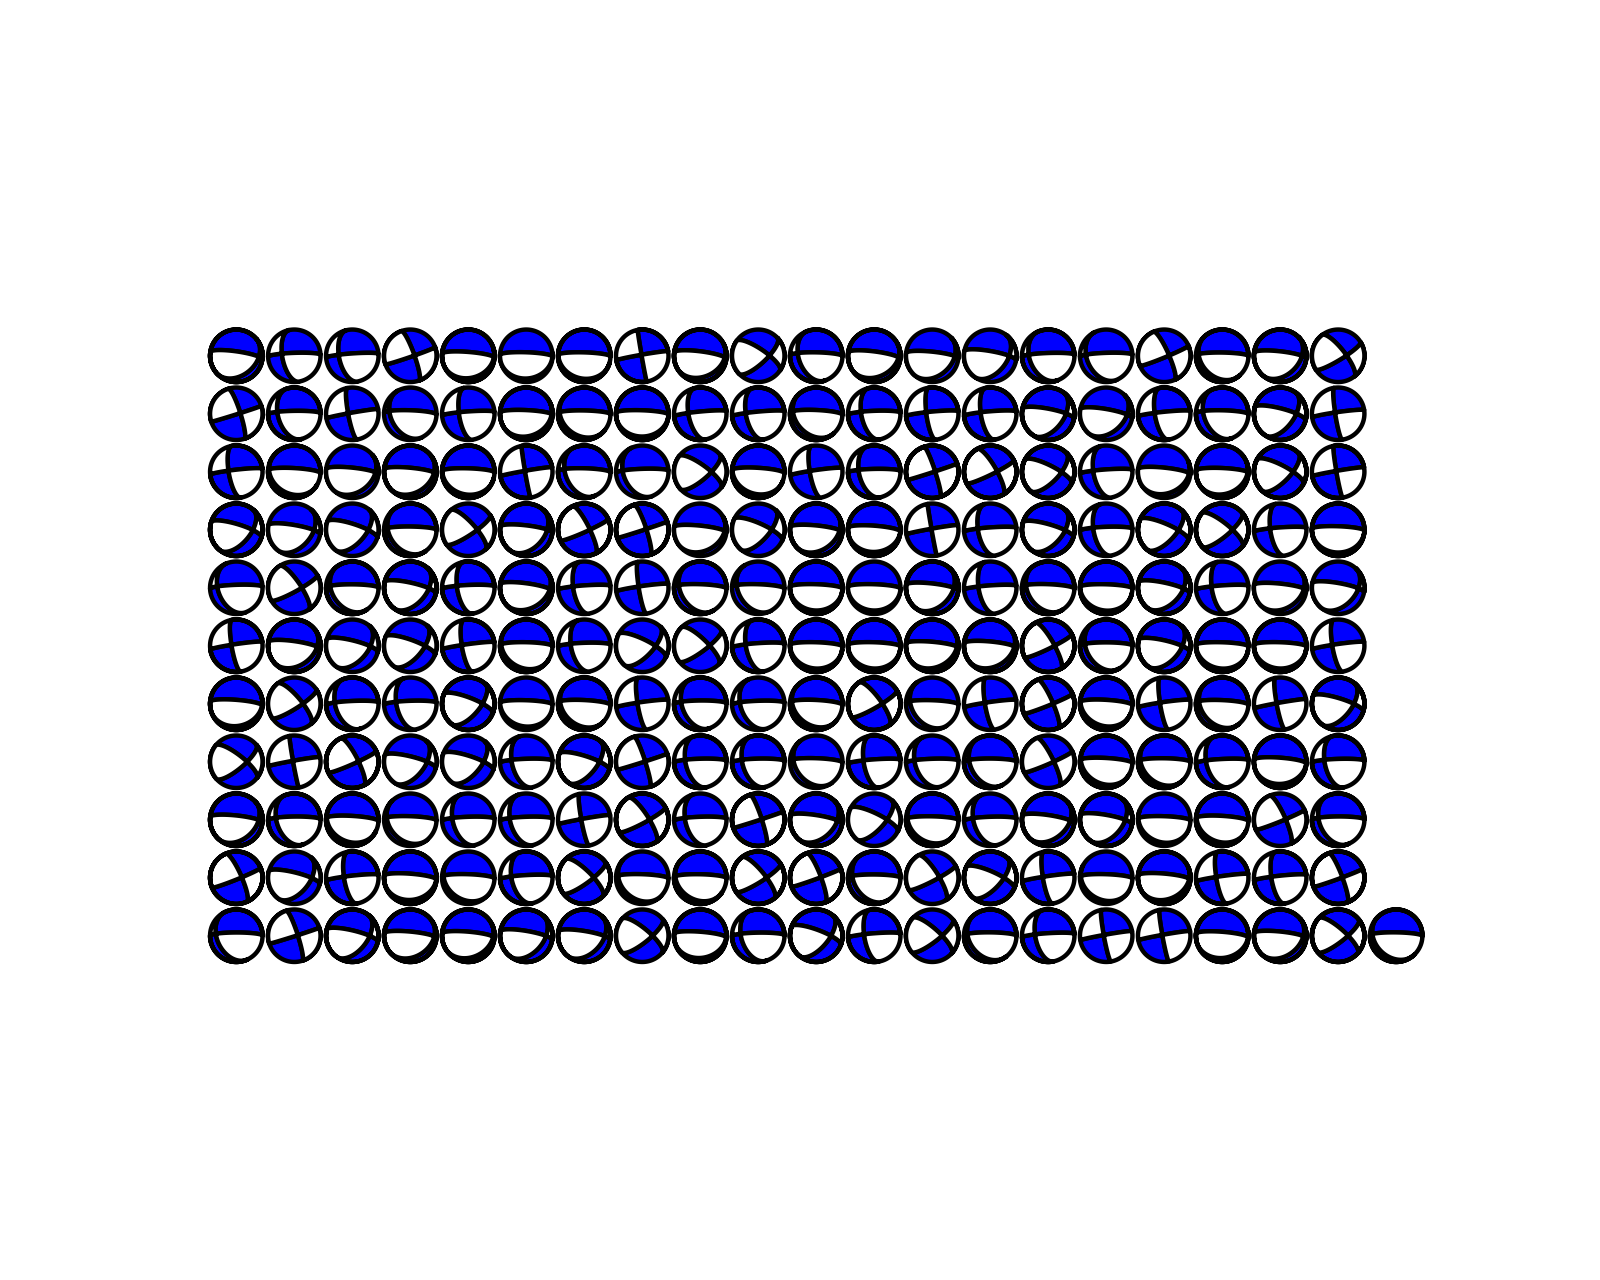

In [29]:
df = pd.read_csv('/Users/maddysita/Desktop/CIERA_REU/event-by-event/EARTHQUAKE/eqANMO_march.csv')


df = df.sort_values('Misfit')

fig = plt.figure(figsize=(10,8))

n = 0
for index,rows in df.iterrows():
    f = [rows.Strike, rows.Dip, rows.Rake]

    if n <= 20:
        fault = beachball(f, xy=(210*n,0), fig=fig)

    elif n <= 40:
        fault = beachball(f, xy=(210*(n-21),210), fig=fig)

    elif n <= 60:
        fault = beachball(f, xy=(210*(n-41),420), fig=fig)

    elif n <= 80:
        fault = beachball(f, xy=(210*(n-61),630), fig=fig)

    elif n <= 100:
        fault = beachball(f, xy=(210*(n-81),840), fig=fig)

    elif n <= 120:
        fault = beachball(f, xy=(210*(n-101),1050), fig=fig)

    elif n <= 140:
        fault = beachball(f, xy=(210*(n-121),1260), fig=fig)

    elif n <= 160:
        fault = beachball(f, xy=(210*(n-141),1470), fig=fig)

    elif n <= 180:
        fault = beachball(f, xy=(210*(n-161),1680), fig=fig)

    elif n <= 200:
        fault = beachball(f, xy=(210*(n-181),1890), fig=fig)
        
    elif n <= 220:
        fault = beachball(f, xy=(210*(n-201),2100), fig=fig)
        
    n+=1

In [19]:
def alphabeach1(df,c):
    fig = plt.figure(figsize=(10,8))

    misfit = df['Misfit']

    max_mis = misfit.max()
    min_mis = misfit.min()

    norm_ls = []
    for value in misfit:
        newval = (max_mis-value)/(max_mis-min_mis)
        norm_ls.append(newval)

    misfit_norm = df.assign(Normalized = norm_ls)
    
    n = 0
    for index,rows in misfit_norm[:870].iterrows():
        f = [rows.Strike, rows.Dip, rows.Rake]

        if n <= 29:
            fault = beachball(f, xy=(210*n,0), facecolor = c, fig=fig, alpha = rows.Normalized)

        elif n <= 59:
            fault = beachball(f, xy=(210*(n-30),210), facecolor = c, fig=fig, alpha = rows.Normalized)

        elif n <= 89:
            fault = beachball(f, xy=(210*(n-60),420), facecolor = c, fig=fig, alpha = rows.Normalized)

        elif n <= 119:
            fault = beachball(f, xy=(210*(n-90),630), facecolor = c, fig=fig, alpha = rows.Normalized)

        elif n <= 149:
            fault = beachball(f, xy=(210*(n-120),840), facecolor = c, fig=fig, alpha = rows.Normalized)

        elif n <= 179:
            fault = beachball(f, xy=(210*(n-150),1050), facecolor = c, fig=fig, alpha = rows.Normalized)

        elif n <= 209:
            fault = beachball(f, xy=(210*(n-180),1260), facecolor = c, fig=fig, alpha = rows.Normalized)

        elif n <= 239:
            fault = beachball(f, xy=(210*(n-210),1470), facecolor = c, fig=fig, alpha = rows.Normalized)

        elif n <= 269:
            fault = beachball(f, xy=(210*(n-240),1680), facecolor = c, fig=fig, alpha = rows.Normalized)

        elif n <= 299:
            fault = beachball(f, xy=(210*(n-270),1890), facecolor = c, fig=fig, alpha = rows.Normalized)

        elif n <= 329:
            fault = beachball(f, xy=(210*(n-300),2100), facecolor = c, fig=fig, alpha = rows.Normalized)

        elif n <= 359:
            fault = beachball(f, xy=(210*(n-330),2310), facecolor = c, fig=fig, alpha = rows.Normalized)

        elif n <= 389:
            fault = beachball(f, xy=(210*(n-360),2520), facecolor = c, fig=fig, alpha = rows.Normalized)

        elif n <= 419:
            fault = beachball(f, xy=(210*(n-390),2730), facecolor = c, fig=fig, alpha = rows.Normalized)

        elif n <= 449:
            fault = beachball(f, xy=(210*(n-420),2940), facecolor = c, fig=fig, alpha = rows.Normalized)

        elif n <= 479:
            fault = beachball(f, xy=(210*(n-450),3150), facecolor = c, fig=fig, alpha = rows.Normalized)

        elif n <= 509:
            fault = beachball(f, xy=(210*(n-480),3360), facecolor = c, fig=fig, alpha = rows.Normalized)

        elif n <= 539:
            fault = beachball(f, xy=(210*(n-510),3570), facecolor = c, fig=fig, alpha = rows.Normalized)

        elif n <= 569:
            fault = beachball(f, xy=(210*(n-540),3780), facecolor = c, fig=fig, alpha = rows.Normalized)

        elif n <= 599:
            fault = beachball(f, xy=(210*(n-570),3990), facecolor = c, fig=fig, alpha = rows.Normalized)
        
        elif n <= 629:
            fault = beachball(f, xy=(210*(n-600),4200), facecolor = c, fig=fig, alpha = rows.Normalized)

        elif n <= 659:
            fault = beachball(f, xy=(210*(n-630),4410), facecolor = c, fig=fig, alpha = rows.Normalized)
        
        elif n <= 689:
            fault = beachball(f, xy=(210*(n-660),4620), facecolor = c, fig=fig, alpha = rows.Normalized)
            
        elif n <= 719:
            fault = beachball(f, xy=(210*(n-690),4830), facecolor = c, fig=fig, alpha = rows.Normalized)
        
        elif n <= 749:
            fault = beachball(f, xy=(210*(n-720),5040), facecolor = c, fig=fig, alpha = rows.Normalized)
        
        elif n <= 779:
            fault = beachball(f, xy=(210*(n-750),5250), facecolor = c, fig=fig, alpha = rows.Normalized)
            
        elif n <= 809:
            fault = beachball(f, xy=(210*(n-780),5460), facecolor = c, fig=fig, alpha = rows.Normalized)
            
        elif n <= 839:
            fault = beachball(f, xy=(210*(n-810),5670), facecolor = c, fig=fig, alpha = rows.Normalized)
        
        elif n <= 869:
            fault = beachball(f, xy=(210*(n-840),5880), facecolor = c, fig=fig, alpha = rows.Normalized)

        n+=1

    return misfit_norm

In [20]:
def alphabeach2(df,c):
    fig = plt.figure(figsize=(10,8))

#     misfit = df['Misfit']

#     max_mis = misfit.max()
#     min_mis = misfit.min()

#     norm_ls = []
#     for value in misfit:
#         newval = (max_mis-value)/(max_mis-min_mis)
#         norm_ls.append(newval)

#     misfit_norm = df.assign(Normalized = norm_ls)
    
    n = 0
    for index,rows in df[871:].iterrows():
        f = [rows.Strike, rows.Dip, rows.Rake]

        if n <= 29:
            fault = beachball(f, xy=(210*n,0), facecolor = c, fig=fig, alpha = rows.Normalized)

        elif n <= 59:
            fault = beachball(f, xy=(210*(n-30),210), facecolor = c, fig=fig, alpha = rows.Normalized)

        elif n <= 89:
            fault = beachball(f, xy=(210*(n-60),420), facecolor = c, fig=fig, alpha = rows.Normalized)

        elif n <= 119:
            fault = beachball(f, xy=(210*(n-90),630), facecolor = c, fig=fig, alpha = rows.Normalized)

        elif n <= 149:
            fault = beachball(f, xy=(210*(n-120),840), facecolor = c, fig=fig, alpha = rows.Normalized)

        elif n <= 179:
            fault = beachball(f, xy=(210*(n-150),1050), facecolor = c, fig=fig, alpha = rows.Normalized)

        elif n <= 209:
            fault = beachball(f, xy=(210*(n-180),1260), facecolor = c, fig=fig, alpha = rows.Normalized)

        elif n <= 239:
            fault = beachball(f, xy=(210*(n-210),1470), facecolor = c, fig=fig, alpha = rows.Normalized)

        elif n <= 269:
            fault = beachball(f, xy=(210*(n-240),1680), facecolor = c, fig=fig, alpha = rows.Normalized)

        elif n <= 299:
            fault = beachball(f, xy=(210*(n-270),1890), facecolor = c, fig=fig, alpha = rows.Normalized)

        elif n <= 329:
            fault = beachball(f, xy=(210*(n-300),2100), facecolor = c, fig=fig, alpha = rows.Normalized)

        elif n <= 359:
            fault = beachball(f, xy=(210*(n-330),2310), facecolor = c, fig=fig, alpha = rows.Normalized)

        elif n <= 389:
            fault = beachball(f, xy=(210*(n-360),2520), facecolor = c, fig=fig, alpha = rows.Normalized)

        elif n <= 419:
            fault = beachball(f, xy=(210*(n-390),2730), facecolor = c, fig=fig, alpha = rows.Normalized)

        elif n <= 449:
            fault = beachball(f, xy=(210*(n-420),2940), facecolor = c, fig=fig, alpha = rows.Normalized)

        elif n <= 479:
            fault = beachball(f, xy=(210*(n-450),3150), facecolor = c, fig=fig, alpha = rows.Normalized)

        elif n <= 509:
            fault = beachball(f, xy=(210*(n-480),3360), facecolor = c, fig=fig, alpha = rows.Normalized)

        elif n <= 539:
            fault = beachball(f, xy=(210*(n-510),3570), facecolor = c, fig=fig, alpha = rows.Normalized)

        elif n <= 569:
            fault = beachball(f, xy=(210*(n-540),3780), facecolor = c, fig=fig, alpha = rows.Normalized)

        elif n <= 599:
            fault = beachball(f, xy=(210*(n-570),3990), facecolor = c, fig=fig, alpha = rows.Normalized)
        
        elif n <= 629:
            fault = beachball(f, xy=(210*(n-600),4200), facecolor = c, fig=fig, alpha = rows.Normalized)

        elif n <= 659:
            fault = beachball(f, xy=(210*(n-630),4410), facecolor = c, fig=fig, alpha = rows.Normalized)
        
        elif n <= 689:
            fault = beachball(f, xy=(210*(n-660),4620), facecolor = c, fig=fig, alpha = rows.Normalized)
            
        elif n <= 719:
            fault = beachball(f, xy=(210*(n-690),4830), facecolor = c, fig=fig, alpha = rows.Normalized)
        
        elif n <= 749:
            fault = beachball(f, xy=(210*(n-720),5040), facecolor = c, fig=fig, alpha = rows.Normalized)
        
        elif n <= 779:
            fault = beachball(f, xy=(210*(n-750),5250), facecolor = c, fig=fig, alpha = rows.Normalized)
            
        elif n <= 809:
            fault = beachball(f, xy=(210*(n-780),5460), facecolor = c, fig=fig, alpha = rows.Normalized)
            
        elif n <= 839:
            fault = beachball(f, xy=(210*(n-810),5670), facecolor = c, fig=fig, alpha = rows.Normalized)
        
        elif n <= 869:
            fault = beachball(f, xy=(210*(n-840),5880), facecolor = c, fig=fig, alpha = rows.Normalized)

        n+=1

    return

1732


<IPython.core.display.Javascript object>


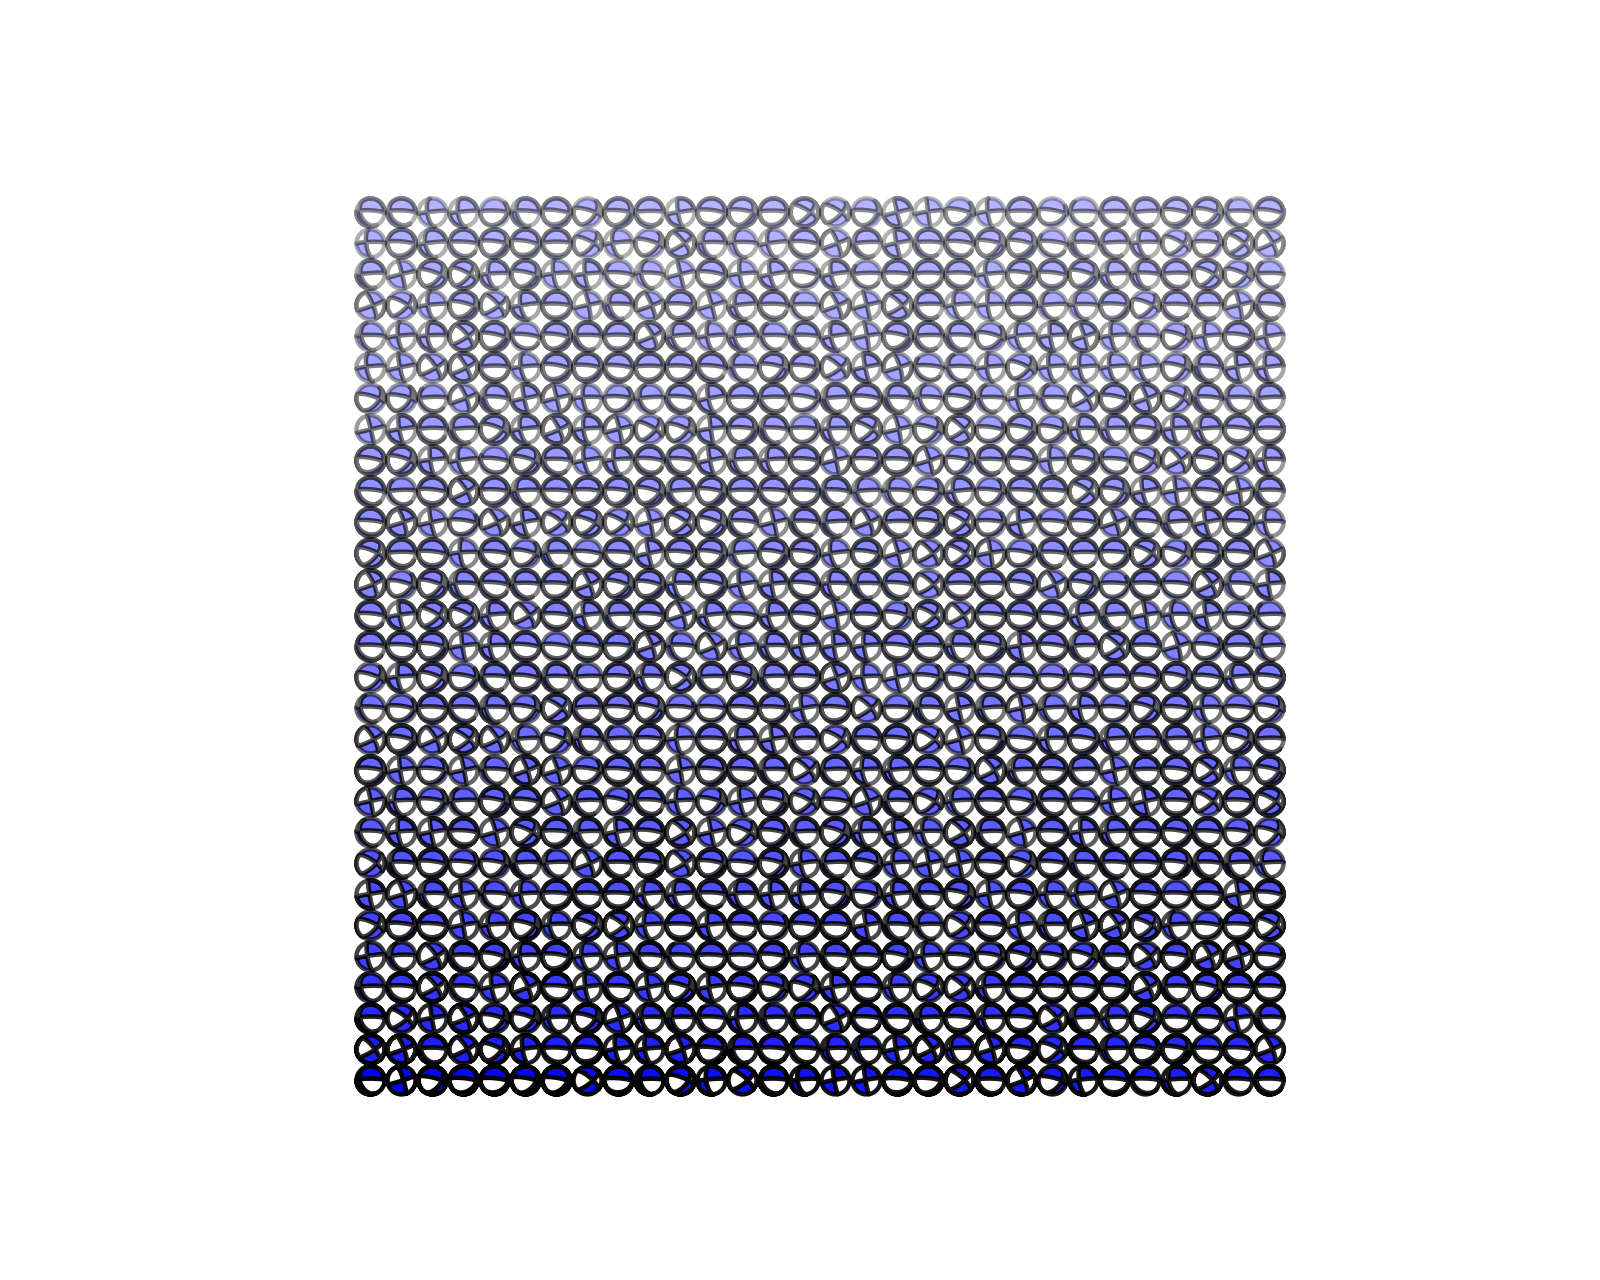

<IPython.core.display.Javascript object>


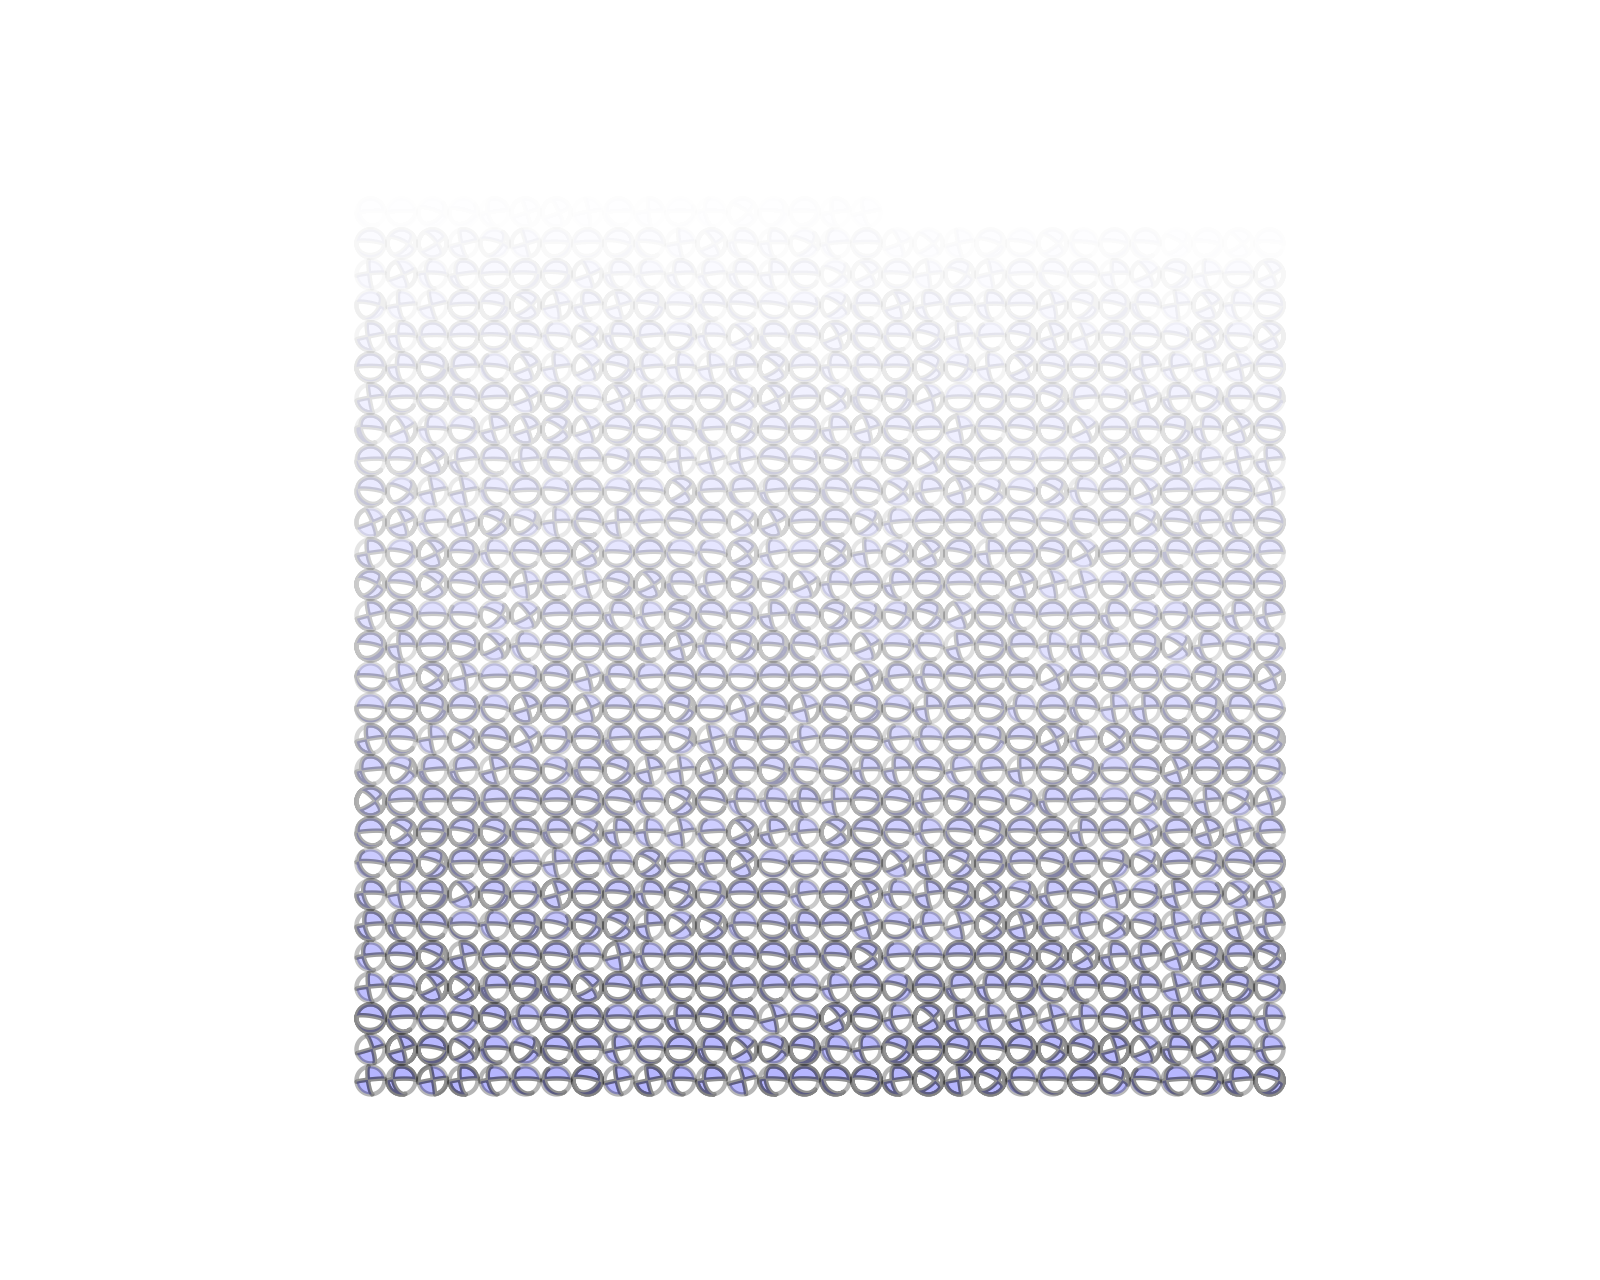

In [21]:
df = pd.read_csv('/Users/maddysita/Desktop/CIERA_REU/event-by-event/EARTHQUAKE/eqANMO_march.csv')
print(len(df))
df2 = alphabeach1(df,'b')
plt.savefig('/Users/maddysita/Desktop/CIERA_REU/script_notebooks/paper_figures/paper_pdfs/beachANMO_1.pdf')
alphabeach2(df2,'b')
plt.savefig('/Users/maddysita/Desktop/CIERA_REU/script_notebooks/paper_figures/paper_pdfs/beachANMO_2.pdf')

698


<IPython.core.display.Javascript object>


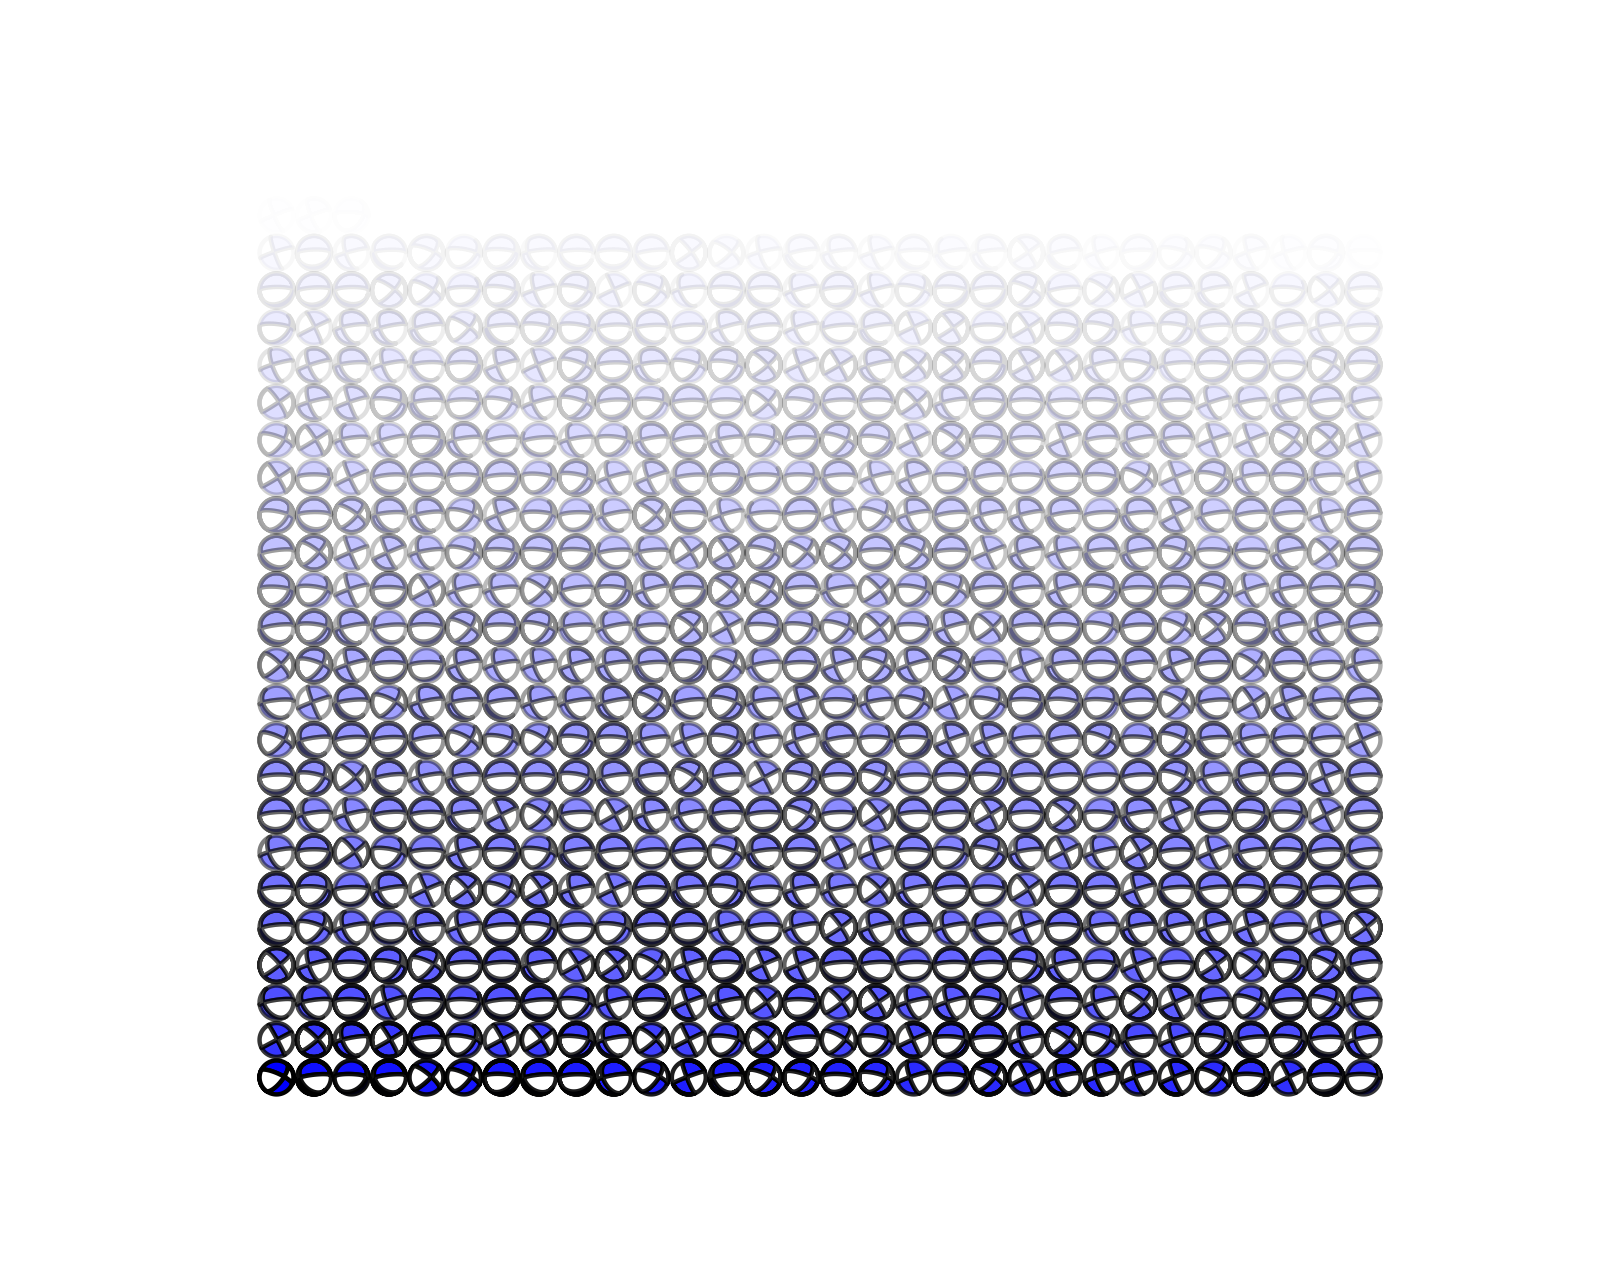

In [23]:
df = pd.read_csv('/Users/maddysita/Desktop/CIERA_REU/event-by-event/EARTHQUAKE/eqCOR_march.csv')
print(len(df))
df2 = alphabeach1(df,'b')
plt.savefig('/Users/maddysita/Desktop/CIERA_REU/script_notebooks/paper_figures/paper_pdfs/beachCOR.pdf')
# alphabeach2(df2,'b')
# plt.savefig('/Users/maddysita/Desktop/CIERA_REU/script_notebooks/paper_figures/paper_pdfs/beachANMO_2.pdf')